# The prior_distributions_2D plot in the paper.

In [2]:
%matplotlib inline

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import kepler_kinematics as kek

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

plotpar = {'axes.labelsize': 22,
                  'font.size': 12,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 15,
                  'ytick.labelsize': 15,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Load data.

In [4]:
df = pd.read_csv("../kepler_kinematics/gaia_kepler_lamost.csv")

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,20,21,22,28,30,54,55,56,74,76,155,156,176) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
mu, cov = kek.get_prior()
print(np.shape(cov))

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,20,21,22,28,30,54,55,56,74,76,155,156,176) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(4, 4)


Function for plotting an ellipse

In [6]:
def confidence_ellipse_mod(x, y, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Define variables for plotting

In [108]:
box = 150
lnD = np.log(df.r_est.values * 1e-3)
m = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) & np.isfinite(df.vz.values) & np.isfinite(lnD)
vx_c, vy_c, vz_c, lnD_c = df.vx.values[m], df.vy.values[m], df.vz.values[m], lnD[m]
medx, medy, medz = np.median(vx_c), np.median(vy_c), np.median(vz_c)
xlim, ylim, zlim, dlim = (medx-box, medx+box), (medy-box, medy+box), (medz-box, medz+box), (-3, 1.75)

alpha, ms, lw, lalpha = .3, .8, .8, 1.
color = "C3" #lightseagreen"
cmap = "viridis_r"
vmin, vmax = 0, .1

For plotting priors:

In [105]:
def gauss(x, mu, sig):
    return 1./(sig * np.sqrt(2 * np.pi)) * np.exp(-.5 * (x - mu)**2 / sig**2)

In [103]:
# get the prior parameters
mu, cov = kek.get_prior()

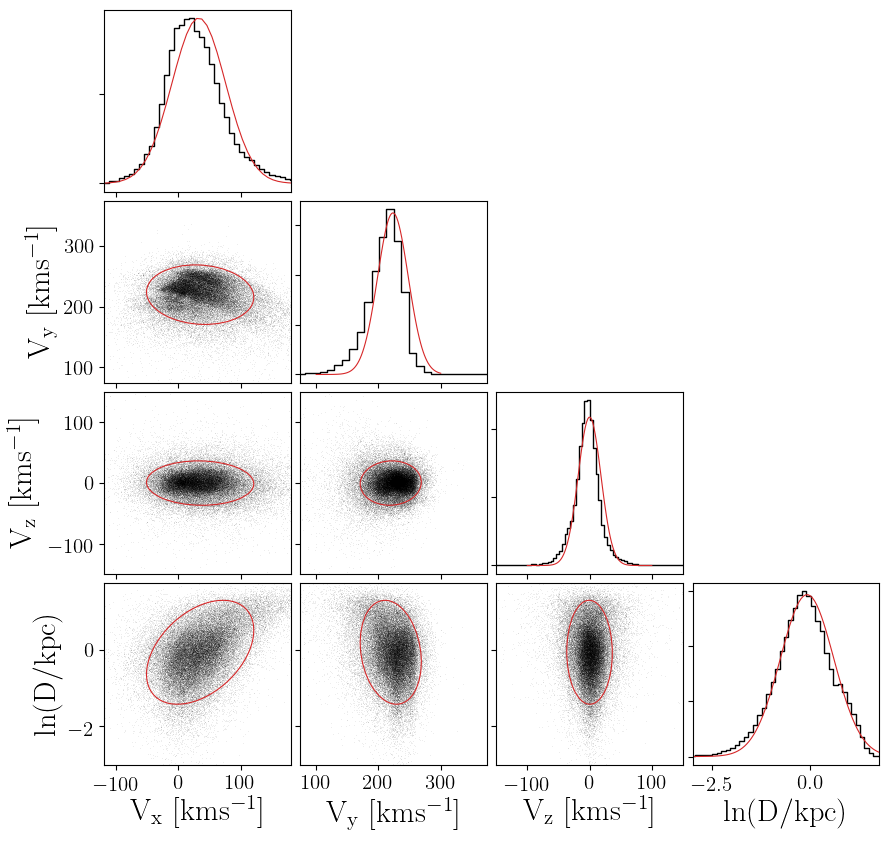

In [110]:
fig = plt.figure(figsize=(10, 10), dpi=100)

# Vx 
axx = fig.add_subplot(441) # 331
h, bins = np.histogram(vx_c, 100, density=True)
axx.step(bins[:-1], h, color="k", lw=1)
xs = np.linspace(bins[0], bins[-1], 100)
axx.plot(xs, gauss(xs, mu[0], np.sqrt(cov[0, 0])), color=color, lw=lw)
axx.set_xlim(xlim)
axx.set_xticklabels([])
axx.set_yticklabels([])

# Vx Vy
axxy = fig.add_subplot(445) # 334
axxy.plot(vx_c, vy_c, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, axxy, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
axxy.set_xlim(xlim)
axxy.set_ylim(ylim)
axxy.set_xticklabels([])
axxy.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

# Vx Vz
axxz = fig.add_subplot(4,4,9) # 337
axxz.plot(vx_c, vz_c, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, axxz, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
axxz.set_ylim(zlim)
axxz.set_xlim(xlim)
axxz.set_xticklabels([])
axxz.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

# Vx lnD
axxd = fig.add_subplot(4,4,13)  # 3,3,10
axxd.plot(vx_c, lnD_c, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# _cov = np.array([[cov[0, 0], cov[3, 0]], [cov[0, 3], cov[3, 3]]])
_cov = np.array([[cov[0, 0], cov[0, 3]], [cov[3, 0], cov[3, 3]]])
confidence_ellipse_mod(vx_c, lnD_c, _cov, axxd, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
axxd.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
axxd.set_ylabel("$\mathrm{\ln(D/kpc)}$")
axxd.set_xlim(xlim)
axxd.set_ylim(dlim)

# Vy
axy = fig.add_subplot(446) # 331
h, bins = np.histogram(vy_c, 100, density=True)
axy.step(bins[:-1], h, color="k", lw=1)
xs = np.linspace(100, 300, 100)
axy.plot(xs, gauss(xs, mu[1], np.sqrt(cov[1, 1])), color=color, lw=lw)
axy.set_xlim(ylim)
axy.set_xticklabels([])
axy.set_yticklabels([])

# Vy Vz
axyz = fig.add_subplot(4,4,10)  # 335
axyz.plot(vy_c, vz_c, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, axyz, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
axyz.set_xlim(ylim)
axyz.set_ylim(zlim)
axyz.set_yticklabels([])
axyz.set_xticklabels([])

# Vy lnD
axyd = fig.add_subplot(4,4,14)  # 338
axyd.plot(vy_c, lnD_c, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
_cov = np.array([[cov[1, 1], cov[1, 3]], [cov[3, 1], cov[3, 3]]])
confidence_ellipse_mod(vy_c, lnD_c, _cov, axyd, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
axyd.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
axyd.set_yticklabels([])
axyd.set_xlim(ylim)
axyd.set_ylim(dlim)

# Vz
axz = fig.add_subplot(4,4,11) # 331
h, bins = np.histogram(vz_c, 100, density=True)
axz.step(bins[:-1], h, color="k", lw=1)
xs = np.linspace(-100, 100, 100)
axz.plot(xs, gauss(xs, mu[2], np.sqrt(cov[2, 2])), color=color, lw=lw)
axz.set_xlim(zlim)
axz.set_xticklabels([])
axz.set_yticklabels([])

# Vz lnD
axzd = fig.add_subplot(4,4,15)  # 339
axzd.plot(vz_c, lnD_c, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
_cov = np.array([[cov[2, 2], cov[2, 3]], [cov[3, 2], cov[3, 3]]])
confidence_ellipse_mod(vz_c, lnD_c,  _cov, axzd, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
axzd.set_xlabel("$\mathrm{V_z~[kms^{-1}]}$")
axzd.set_yticklabels([])
axzd.set_ylim(dlim)
axzd.set_xlim(zlim)

# lnD
axd = fig.add_subplot(4,4,16) # 331
h, bins = np.histogram(lnD_c, 50, density=True)
axd.step(bins[:-1], h, color="k", lw=1)
xs = np.linspace(bins[0], bins[-1], 100)
axd.plot(xs, gauss(xs, mu[3], np.sqrt(cov[3, 3])), color=color, lw=lw)
axd.set_xlim(dlim)
axd.set_yticklabels([])
axd.set_xlabel("$\mathrm{\ln(D/kpc)}$")

# plt.tight_layout()
plt.subplots_adjust(hspace=.05, wspace=.05)
# plt.savefig("../plots/prior_distributions_2D")
# plt.savefig("../paper/prior_distributions_2D.pdf")